# Summary of the extracted data

This notebook contains the code to perform a summary of the initial tweets extracted. 
It includes:
- number of user
- number of tweets per user (average)
- barplot with tweets per year and category 
- pie chart with % of tweets per category

**Note that to obtain these numbers and perform the previous graphics we will use the "semiclean" data, tweets after all the filtering steps but previous to removing the tweets that refer to more than one category.** 

Additionally, and based on external information, we also create a barplot with the tweets in english per year. 

In [298]:
#####################
# Load Libraries    #
#####################
#install.packages(c("ggplot2", "dplyr", "scales", "viridis") )
install.packages("Kendall")
install.packages("wordcloud")
install.packages("tm")
install.packages("slam")
library("Kendall")
library("ggplot2")
library("dplyr")
library("scales")
library("viridis")
library("reshape2")
library("wordcloud")
library("tm")
library("slam")
rm(list=ls())

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: RColorBrewer


First, we read all the files in the "SemiCleanAndAggregateTweets" and we put all of them together. 

In [299]:
#################################
# TWEETS PER YEAR AND CATEGORY #
################################
fileList <- list.files("/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/", pattern = "_SemiCleanTweets.txt")

for( i in 1:length( fileList ) ){
    
    if( i == 1 ){
        totalSemiCleanTweets <- read.delim(paste0( "/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/", fileList[i]))
    }else{
        intermediateFile <- read.delim(paste0( "/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/", fileList[i]))
        totalSemiCleanTweets <- rbind( totalSemiCleanTweets, intermediateFile )
    }
}

dim(totalSemiCleanTweets)

[1] 838739     12

Then, we estimate the total number of users and the tweets per user. 

In [64]:
###############################################
## Estimate total users and tweets per user ##
##############################################
length(unique(totalSemiCleanTweets$username))
tweetsPerUser <- as.data.frame( table( totalSemiCleanTweets$username))
summary(tweetsPerUser$Freq)
head(tweetsPerUser)

sum(tweetsPerUser$Freq>100)

[1] 424439

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.000    1.000    1.000    1.976    2.000 2737.000 

Var1,Freq
__________zoe,1
____chopp,1
____luckylefty,3
____oh____ok,3
___almost,3
___bambina___,10


[1] 123

## Tweets per category and year
We read all the tweets in the "SemiCleanAndAggregateTweets" folder and we extract for each tweet the year when it was published and we re-write the files to save the information. 

In [280]:
fileList <- list.files("/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/", pattern = "_SemiCleanTweets.txt")

for( i in 1:length( fileList ) ){

      allInfo <- read.delim(paste0( "/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/", fileList[i]))
      allInfo  <- allInfo[, c("text", "date")]
      allInfo$year <- sapply(strsplit( as.character(allInfo$date), "-"), '[', 1)
      allInfo$yearMonth <- paste0( sapply(strsplit( as.character(allInfo$date), "-"), '[', 1), "-",
                                       sapply(strsplit( as.character(allInfo$date), "-"), '[', 2) )
      years <- sort(unique( allInfo$year))
      results <- as.data.frame( matrix( ncol = 2, nrow= length( years )))
      colnames(results) <- c("year", "totalTweets")
      results$year <- years
      
      for( j in 1:nrow(results)){
          results$totalTweets[j] <- nrow( allInfo[ allInfo$year == results$year[j], ] )
      }
    results$category <- gsub( "_SemiCleanTweets.txt", "", fileList[i])
    write.table( results, file= paste0( "/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/", results$category[1],"_tweetsPerYear.txt"), 
                                      col.names = TRUE, row.names = FALSE, sep = "\t", quote = FALSE)

}

Then, we read the new files generated with the year and put all of them together, creating at the end a table with number of tweets per category and year. 

In [281]:
fileList <- list.files("/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/", pattern = "_tweetsPerYear.txt")
fileList 

for( i in 1:length( fileList ) ){
  
  if( i == 1){
    allInfo <- read.delim(paste0( "/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/", fileList[i]))
  }else{
    newFile <- read.delim(paste0( "/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/", fileList[i]))
    allInfo <- rbind( allInfo, newFile )
  }
}

byYearTweets <- allInfo[ allInfo$year != "Total", ]
dataSet <- byYearTweets[, c("year", "totalTweets", "category")]
dataSet$year <- as.factor( dataSet$year)

[1] "copperIUD_tweetsPerYear.txt" "Implant_tweetsPerYear.txt"  
[3] "IUD_tweetsPerYear.txt"       "LNG-IUD_tweetsPerYear.txt"  
[5] "Patch_tweetsPerYear.txt"     "Pill_tweetsPerYear.txt"     
[7] "Ring_tweetsPerYear.txt"      "Shot_tweetsPerYear.txt"

With this data generated, we create a stacked barplot showing tweets per each BC category and per year.

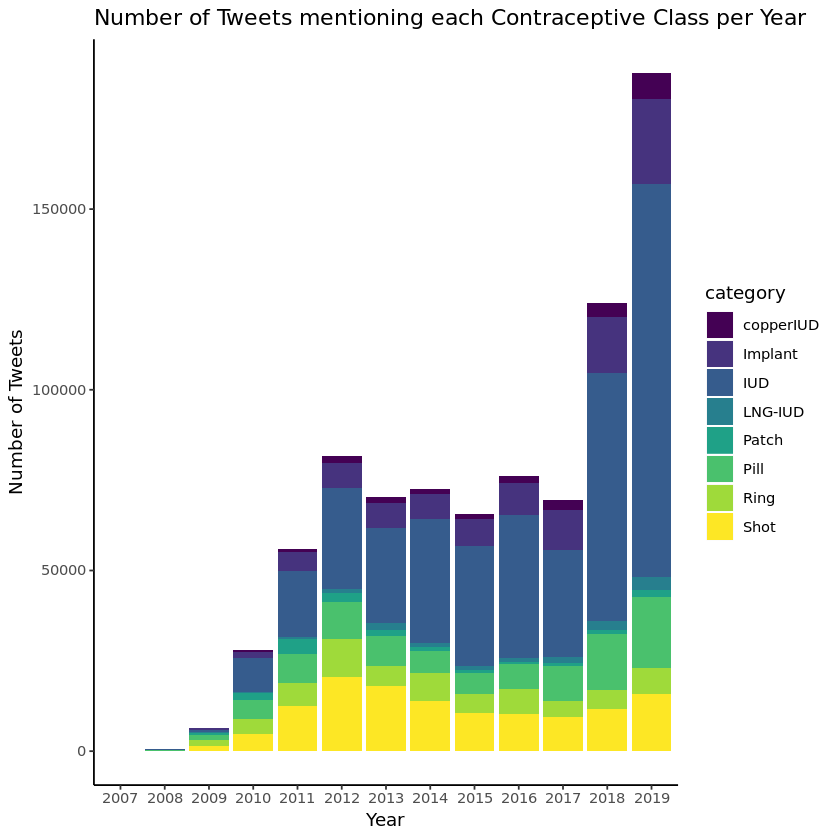

In [259]:
############################################################
# Stacked barplot with tweets of each BC category per year #
############################################################
barTotalByYear <- ggplot(dataSet, aes(fill=category, y=totalTweets, x=year)) + 
  geom_bar(position="stack", stat="identity") + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))+
  ggtitle("Number of Tweets mentioning each Contraceptive Class per Year") +
  xlab("Year") +
  ylab( "Number of Tweets") +
  scale_fill_viridis_d()

barTotalByYear

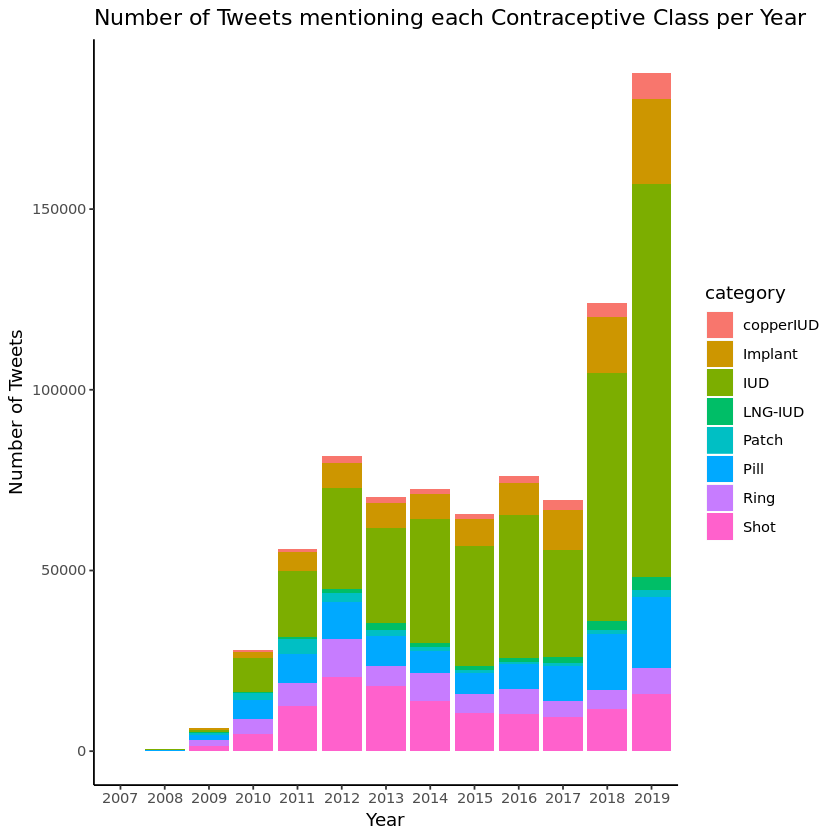

In [285]:
############################################################
# Stacked barplot with tweets of each BC category per year 2 #
############################################################
barTotalByYear2 <- ggplot(dataSet, aes(fill=category, y=totalTweets, x=year)) + 
  geom_bar(position="stack", stat="identity") + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))+
  ggtitle("Number of Tweets mentioning each Contraceptive Class per Year") +
  xlab("Year") +
  ylab( "Number of Tweets")

barTotalByYear2

## Summary table for semi clean tweets

In [192]:
#first we get all the files names
fileList <- list.files("/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/", pattern = "_SemiCleanTweets.txt")

#then we create a table to save the summary that we want to generate
summaryTable <- as.data.frame( matrix( ncol = 10, nrow = 16))
colnames(summaryTable) <- c("Year", "IUD_tweets", "LNG-IUD_tweets", "copperIUD_tweets", "Implant_tweets", 
                            "Patch_tweets", "Pill_tweets", "Ring_tweets", "Shot_tweets", "TotalTweetsPerYear")
summaryTable$Year <- c("2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", 
                       "2018", "2019", "totalTweetsPerCategory", "MannKendall_pVal", "MannKendall_tau")

In [219]:
#then with a for loop, we estimates the counts for each category and we fill the summary table

categories <- gsub("_SemiCleanTweets.txt", "", fileList)

for( i in 1:length( categories ) ){

    columnToFill <- which( colnames(summaryTable)== paste0(categories[i], "_tweets" ))
    allInfo <- read.delim(paste0( "/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/", categories[i], "_SemiCleanTweets.txt"))
    allInfo  <- allInfo[, c("text", "date")]
    allInfo$year <- sapply(strsplit( as.character(allInfo$date), "-"), '[', 1)

    summaryTable[ summaryTable$Year == "2007", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2007, ]))
    summaryTable[ summaryTable$Year == "2008", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2008, ]))
    summaryTable[ summaryTable$Year == "2009", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2009, ]))
    summaryTable[ summaryTable$Year == "2010", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2010, ]))
    summaryTable[ summaryTable$Year == "2011", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2011, ]))
    summaryTable[ summaryTable$Year == "2012", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2012, ]))
    summaryTable[ summaryTable$Year == "2013", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2013, ]))
    summaryTable[ summaryTable$Year == "2014", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2014, ]))
    summaryTable[ summaryTable$Year == "2015", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2015, ]))
    summaryTable[ summaryTable$Year == "2016", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2016, ]))
    summaryTable[ summaryTable$Year == "2017", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2017, ]))
    summaryTable[ summaryTable$Year == "2018", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2018, ]))
    summaryTable[ summaryTable$Year == "2019", columnToFill] <- as.numeric(nrow(allInfo[ allInfo$year == 2019, ]))
    summaryTable[ summaryTable$Year == "totalTweetsPerCategory", columnToFill] <- nrow(allInfo)
    summaryTable[ summaryTable$Year == "MannKendall_tau", columnToFill] <-  round( MannKendall(summaryTable[1:13, columnToFill])$tau, 3 )
    summaryTable[ summaryTable$Year == "MannKendall_pVal", columnToFill] <- formatC( as.numeric( MannKendall(summaryTable[1:13, columnToFill])$sl ), digits = 3 ) 
}

#change characters to numerics to estimate the total per year
for( i in 1:14){
    summaryTable$TotalTweetsPerYear[i] <- sum( as.numeric( summaryTable[i, c(2:9)]))
}
summaryTable

Year,IUD_tweets,LNG-IUD_tweets,copperIUD_tweets,Implant_tweets,Patch_tweets,Pill_tweets,Ring_tweets,Shot_tweets,TotalTweetsPerYear
2007,16,0,0,0,2,14,0,3,35
2008,333,7,6,20,89,120,50,54,679
2009,676,199,133,452,470,1478,1556,1551,6515
2010,9369,476,512,1485,1934,5262,4105,4729,27872
2011,18439,574,789,5120,3969,8202,6279,12517,55889
2012,28018,1068,1977,6957,2317,10301,10587,20516,81741
2013,26317,2004,1630,6956,1555,8343,5531,17987,70323
2014,34099,1065,1306,7009,1318,6066,7731,13838,72432
2015,33238,1008,1438,7529,758,5971,5089,10628,65659
2016,39508,1268,2146,8708,614,6817,6928,10260,76249


### Mann Kendall tests for trends in number of tweets per class over time

In [110]:
#########################################################################
# Mann Kendall tests for trends in number of tweets per class over time #
#########################################################################

#IUD
mk <- read.delim("/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/IUD_tweetsPerYear.txt")
mk <- mk[, c("year", "totalTweets", "category")]
as.data.frame(mk, row.names = NULL, col.names = TRUE,)
mk <- mk[,-3]

paste("Mann Kendall test for trend in number of tweets mentioning the IUD over time")
MannKendall(mk$totalTweets)

rm(mk)

#Copper IUD
mk <- read.delim("/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/copperIUD_tweetsPerYear.txt")
mk <- mk[, c("year", "totalTweets", "category")]
as.data.frame(mk, row.names = NULL, col.names = TRUE,)
mk <- mk[,-3]

paste("Mann Kendall test for trend in number of tweets mentioning the Copper IUD over time")
MannKendall(mk$totalTweets)

rm(mk)

#LNG-IUD
mk <- read.delim("/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/LNG-IUD_tweetsPerYear.txt")
mk <- mk[, c("year", "totalTweets", "category")]
as.data.frame(mk, row.names = NULL, col.names = TRUE,)
mk <- mk[,-3]

paste("Mann Kendall test for trend in number of tweets mentioning the LNG-IUD over time")
MannKendall(mk$totalTweets)

rm(mk)

#Implant
mk <- read.delim("/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/Implant_tweetsPerYear.txt")
mk <- mk[, c("year", "totalTweets", "category")]
as.data.frame(mk, row.names = NULL, col.names = TRUE,)
mk <- mk[,-3]

paste("Mann Kendall test for trend in number of tweets mentioning the implant over time")
MannKendall(mk$totalTweets)

rm(mk)

#Pill
mk <- read.delim("/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/Pill_tweetsPerYear.txt")
mk <- mk[, c("year", "totalTweets", "category")]
as.data.frame(mk, row.names = NULL, col.names = TRUE,)
mk <- mk[,-3]

paste("Mann Kendall test for trend in number of tweets mentioning the pill over time")
MannKendall(mk$totalTweets)

rm(mk)

#Patch
mk <- read.delim("/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/Patch_tweetsPerYear.txt")
mk <- mk[, c("year", "totalTweets", "category")]
as.data.frame(mk, row.names = NULL, col.names = TRUE,)
mk <- mk[,-3]

paste("Mann Kendall test for trend in number of tweets mentioning the patch over time")
MannKendall(mk$totalTweets)

rm(mk)

#Ring
mk <- read.delim("/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/Ring_tweetsPerYear.txt")
mk <- mk[, c("year", "totalTweets", "category")]
as.data.frame(mk, row.names = NULL, col.names = TRUE,)
mk <- mk[,-3]

paste("Mann Kendall test for trend in number of tweets mentioning the ring over time")
MannKendall(mk$totalTweets)

rm(mk)

#Shot
mk <- read.delim("/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/Shot_tweetsPerYear.txt")
mk <- mk[, c("year", "totalTweets", "category")]
as.data.frame(mk, row.names = NULL, col.names = TRUE,)
mk <- mk[,-3]

paste("Mann Kendall test for trend in number of tweets mentioning the shot over time")
MannKendall(mk$totalTweets)

rm(mk)

year,totalTweets,category
2007,16,IUD
2008,333,IUD
2009,676,IUD
2010,9369,IUD
2011,18439,IUD
2012,28018,IUD
2013,26317,IUD
2014,34099,IUD
2015,33238,IUD
2016,39508,IUD


[1] "Mann Kendall test for trend in number of tweets mentioning the IUD over time"

tau = 0.872, 2-sided pvalue =4.3631e-05

year,totalTweets,category
2008,6,copperIUD
2009,133,copperIUD
2010,512,copperIUD
2011,789,copperIUD
2012,1977,copperIUD
2013,1630,copperIUD
2014,1306,copperIUD
2015,1438,copperIUD
2016,2146,copperIUD
2017,2999,copperIUD


[1] "Mann Kendall test for trend in number of tweets mentioning the Copper IUD over time"

tau = 0.848, 2-sided pvalue =0.00016224

year,totalTweets,category
2008,7,LNG-IUD
2009,199,LNG-IUD
2010,476,LNG-IUD
2011,574,LNG-IUD
2012,1068,LNG-IUD
2013,2004,LNG-IUD
2014,1065,LNG-IUD
2015,1008,LNG-IUD
2016,1268,LNG-IUD
2017,1672,LNG-IUD


[1] "Mann Kendall test for trend in number of tweets mentioning the LNG-IUD over time"

tau = 0.788, 2-sided pvalue =0.00047016

year,totalTweets,category
2008,20,Implant
2009,452,Implant
2010,1485,Implant
2011,5120,Implant
2012,6957,Implant
2013,6956,Implant
2014,7009,Implant
2015,7529,Implant
2016,8708,Implant
2017,10967,Implant


[1] "Mann Kendall test for trend in number of tweets mentioning the implant over time"

tau = 0.97, 2-sided pvalue =1.5616e-05

year,totalTweets,category
2007,14,Pill
2008,120,Pill
2009,1478,Pill
2010,5262,Pill
2011,8202,Pill
2012,10301,Pill
2013,8343,Pill
2014,6066,Pill
2015,5971,Pill
2016,6817,Pill


[1] "Mann Kendall test for trend in number of tweets mentioning the pill over time"

tau = 0.692, 2-sided pvalue =0.001223

year,totalTweets,category
2007,2,Patch
2008,89,Patch
2009,470,Patch
2010,1934,Patch
2011,3969,Patch
2012,2317,Patch
2013,1555,Patch
2014,1318,Patch
2015,758,Patch
2016,614,Patch


[1] "Mann Kendall test for trend in number of tweets mentioning the patch over time"

tau = 0.179, 2-sided pvalue =0.42771

year,totalTweets,category
2008,50,Ring
2009,1556,Ring
2010,4105,Ring
2011,6279,Ring
2012,10587,Ring
2013,5531,Ring
2014,7731,Ring
2015,5089,Ring
2016,6928,Ring
2017,4396,Ring


[1] "Mann Kendall test for trend in number of tweets mentioning the ring over time"

tau = 0.333, 2-sided pvalue =0.14986

year,totalTweets,category
2007,3,Shot
2008,54,Shot
2009,1551,Shot
2010,4729,Shot
2011,12517,Shot
2012,20516,Shot
2013,17987,Shot
2014,13838,Shot
2015,10628,Shot
2016,10260,Shot


[1] "Mann Kendall test for trend in number of tweets mentioning the shot over time"

tau = 0.385, 2-sided pvalue =0.076851

In [296]:
#LARC
mk <- c(16, 346, 1008, 10357, 19802, 31063, 29951, 36470, 35684, 42922, 34383, 75213, 119656)
MannKendall(mk)

rm(mk)

#SARC 
mk <- c(19, 313, 5055, 16030, 30967, 43721, 33416, 28953, 22446, 24619, 24291, 33412, 44511)
MannKendall(mk) 

rm(mk)

tau = 0.872, 2-sided pvalue =4.3631e-05

tau = 0.513, 2-sided pvalue =0.017343

And we can create a stacked bar plot adusted for the total number of tweets about contraception per year

In [288]:
categories <-  c("IUD", "LNG-IUD", "copperIUD", "Implant",  "Patch", "Ring", "Shot", "Pill")
for( i in 1:length(categories ) ){
    
    if( i ==1 ){
        selection  <- read.delim( paste0( '/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/', categories[i], "_SemiCleanTweets.txt"), header = TRUE)
        selection  <- selection[, c("text", "date")]
        selection$year <- sapply(strsplit( as.character(selection$date), "-"), '[', 1)
        selection$yearMonth <- paste0( sapply(strsplit( as.character(selection$date), "-"), '[', 1), "-",
                                       sapply(strsplit( as.character(selection$date), "-"), '[', 2) )
        colnames(selection)[1] <- "tweets"
        selection$category <- categories[i]
    
    }else{
        selectionInt  <- read.delim( paste0( '/home/ec2-user/SageMaker/SemiCleanAndAggregateTweets/', categories[i], "_SemiCleanTweets.txt"), header = TRUE)
        selectionInt  <- selectionInt[, c("text", "date")]
        selectionInt$year <- sapply(strsplit( as.character(selectionInt$date), "-"), '[', 1)
        selectionInt$yearMonth <- paste0( sapply(strsplit( as.character(selectionInt$date), "-"), '[', 1), "-",
                                       sapply(strsplit( as.character(selectionInt$date), "-"), '[', 2) )
        colnames(selectionInt)[1] <- "tweets"
        
        selectionInt$category <- categories[i]
        
        selection <- rbind( selection, selectionInt)
    }
}

In [263]:
########################################
## Function to create adjusted barplot #
########################################
adjustedBarplot <- function( input, title ){
    ggplot(input, aes(x=as.factor(year), fill=as.factor(category)))+
    geom_bar(aes( y=..count../tapply(..count.., ..x.. ,sum)[..x..]), position="stack" ) +
    scale_y_continuous(labels = scales::percent)+
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          panel.background = element_blank(), axis.line = element_line(colour = "black"))+
    ggtitle( title ) +
    xlab("Year" ) +
    ylab( "% of Tweets")+
  scale_fill_viridis_d()
}

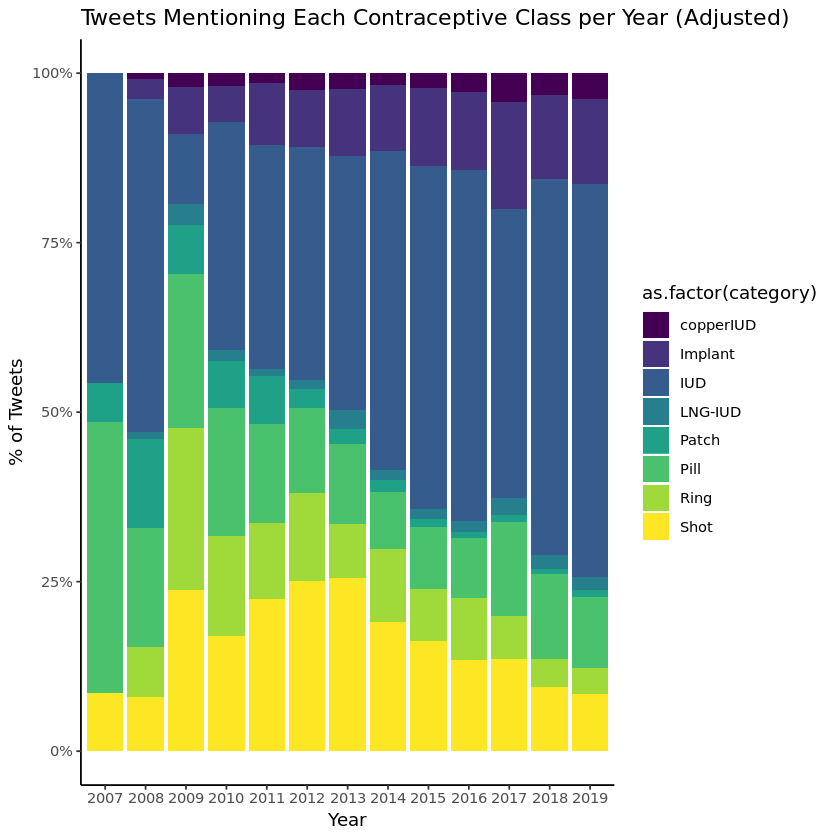

In [264]:
adjustedBarplot( input = selection, 
                 title = "Tweets Mentioning Each Contraceptive Class per Year (Adjusted)" )

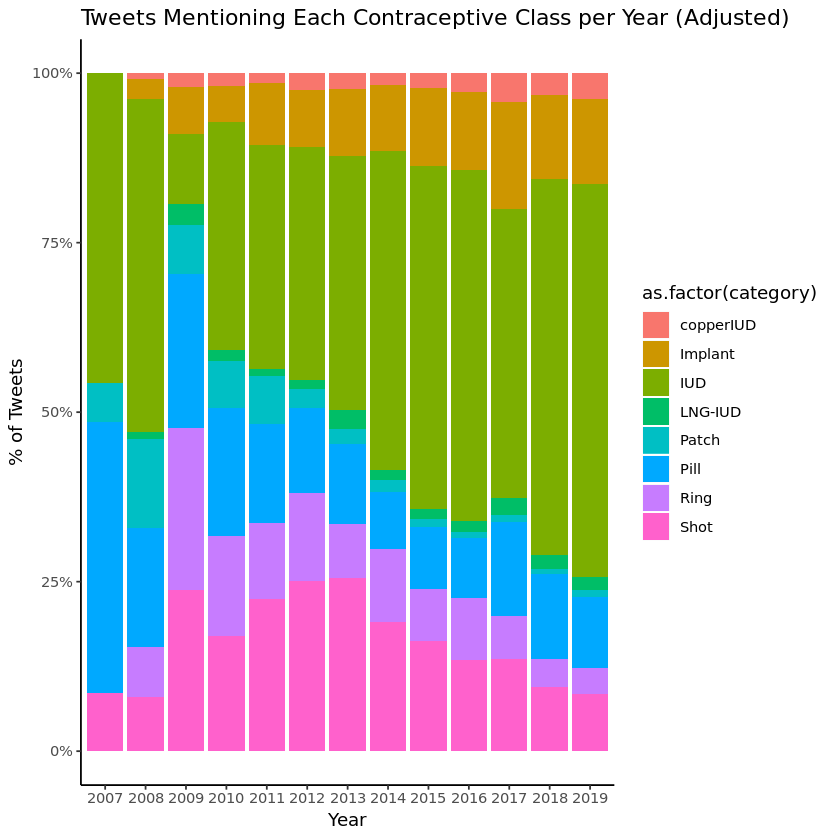

In [292]:
########################################
## Function to create adjusted barplot 2#
########################################
adjustedBarplot2 <- function( input, title ){
    ggplot(input, aes(x=as.factor(year), fill=as.factor(category)))+
    geom_bar(aes( y=..count../tapply(..count.., ..x.. ,sum)[..x..]), position="stack" ) +
    scale_y_continuous(labels = scales::percent)+
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          panel.background = element_blank(), axis.line = element_line(colour = "black"))+
    ggtitle( title ) +
    xlab("Year" ) +
    ylab( "% of Tweets")
}

adjustedBarplot2( input = selection, 
                 title = "Tweets Mentioning Each Contraceptive Class per Year (Adjusted)" )

## Tweets per category
And we also create a general pie chart with the percentage of tweets per category. 

In [7]:
#############################
###TOTAL TWEETS BY CATEGORY #
#############################
totalData <- as.data.frame( matrix( ncol=2, nrow=8))
colnames(totalData) <- c("category", "totalTweets")
totalData$category <- unique( dataSet$category)

for( i in 1:nrow( totalData ) ){
    selection <- dataSet[ dataSet$category == totalData$category[i], ]
    totalData$totalTweets[i] <- sum(selection$totalTweets)
}

totalData %>%
arrange(desc(totalTweets)) %>%
mutate(prop = scales::percent(totalTweets / sum(totalTweets))) -> totalData 

totalData

category,totalTweets,prop
IUD,397213,47.4%
Shot,129022,15.4%
Pill,97554,11.6%
Implant,94115,11.2%
Ring,64647,7.7%
copperIUD,24122,2.9%
Patch,16511,2.0%
LNG-IUD,15520,1.9%


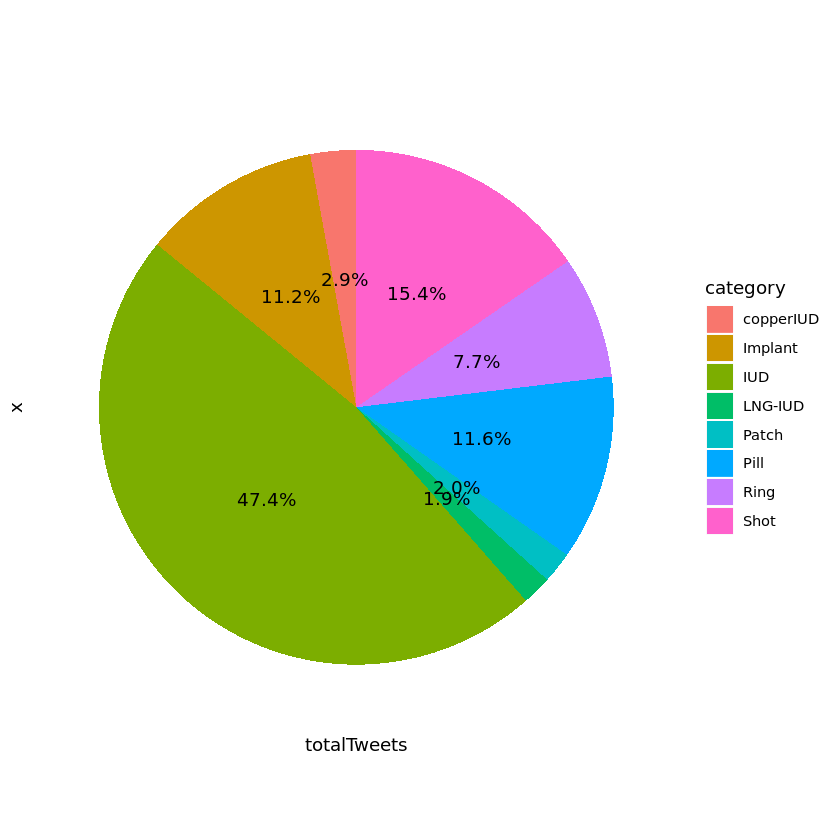

In [9]:
ggplot(totalData, aes(x="", y=totalTweets, fill=category) )+
  geom_bar(width = 1, stat = "identity") +
  coord_polar(theta = "y") +
 geom_text(aes(label = prop),
            position = position_stack(vjust = 0.5)) +

  theme(axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid  = element_blank(), 
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank())

## Alternative using pie donut chart, to agreggate in the pie LARC and SARC

In [290]:
install.packages("rlang")
if(!require(devtools)) install.packages("devtools")
devtools::install_github("cardiomoon/moonBook")
devtools::install_github("cardiomoon/webr", dependencies = TRUE)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: devtools
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘devtools’”also installing the dependencies ‘ini’, ‘clisymbols’, ‘fs’, ‘gh’, ‘rprojroot’, ‘rex’, ‘crosstalk’, ‘xopen’, ‘brew’, ‘commonmark’, ‘purrr’, ‘praise’, ‘usethis’, ‘covr’, ‘desc’, ‘DT’, ‘ellipsis’, ‘git2r’, ‘memoise’, ‘pkgbuild’, ‘pkgload’, ‘rcmdcheck’, ‘remotes’, ‘roxygen2’, ‘rversions’, ‘sessioninfo’, ‘testthat’

Warning message in install.packages("devtools"):
“installation of package ‘gh’ had non-zero exit status”Warning message in install.packages("devtools"):
“installation of package ‘usethis’ had non-zero exit status”Warning message in install.packages("devtools"):
“installation of package ‘devtools’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


ERROR: Error in loadNamespace(name): there is no package called ‘devtools’


In [293]:
fileList <- list.files("/home/ec2-user/SageMaker/CleanAndAggregateTweets/")

for( i in 1:length(fileList)){
    if(i ==1){
        all <- read.delim(paste0( "/home/ec2-user/SageMaker/CleanAndAggregateTweets/", fileList[i]))
        all$Category <- gsub("_CleanTweets.txt", "", fileList[i])
        if( gsub("_CleanTweets.txt", "", fileList[i]) %in% c("copperIUD","Implant", "IUD", "LNG-IUD" )){
            all$BigCategory <- "LARC"
        }else{
            all$BigCategory <- "Non-LARC"
        }
        all <- all[, c("Category", "BigCategory")]
    }else{
        new <- read.delim(paste0( "/home/ec2-user/SageMaker/CleanAndAggregateTweets/", fileList[i]))
        new$Category <- gsub("_CleanTweets.txt", "", fileList[i])
        if( gsub("_CleanTweets.txt", "", fileList[i]) %in% c("copperIUD","Implant", "IUD", "LNG-IUD" )){
            new$BigCategory <- "LARC"
        }else{
            new$BigCategory <- "Non-LARC"
        }
        new <- new[, c("Category", "BigCategory")] 
        all <- rbind(all, new)
    }
}

write.table(all, 
            file="/home/ec2-user/SageMaker/allForPieDonut.txt", 
            col.names = TRUE, 
            row.names = FALSE, 
            quote = FALSE, 
            sep = "\t")

In [ ]:
#the PieDonut function does not work here yet because the moonBook library cannot be installed in this R version
#but I run it locally on my laptopt
colnames(all)[2] <- "Tweets"
#to sort it as we want we change the label names: 
all$Category <- gsub( "copperIUD", "1.Copper", all$Category)
all$Category <- gsub( "LNG-IUD", "2.LNG", all$Category)
all$Category <- gsub( "Implant", "3.Implant", all$Category)
all$Category <- gsub( "IUD", "0.IUD", all$Category)

PieDonut(all,aes(Tweets,Category),explode=1,explodeDonut=FALSE)

![Pie Donut](pieDonut.png)


## Tweets published in Twitter in english per year
We read a file with the information extracted from different external sources. 

In [23]:
#########################
### TWEETS IN ENGLISH ###
#########################
tweetPerYear <- read.csv("/home/ec2-user/SageMaker/tweetsPerYear/tweets_per_yearUpdated.csv", header = TRUE)
tweetPerYear <- tweetPerYear[, c("year", "adjusted_bc_tweets")]

tweetPerYear$yearOnly <- sapply(strsplit( as.character(tweetPerYear$year), " - "), '[', 1) #extract the year
tweetPerYear$totalNumbers <- sapply(strsplit( as.character(tweetPerYear$year), " - "), '[', 2) #extract the total number
tweetPerYear$totalNumbersSN <- formatC( as.numeric( tweetPerYear$totalNumbers ), digits = 3 ) #put the adjusted number in scientific format
tweetPerYear <- tweetPerYear[, c("yearOnly", "totalNumbersSN", "adjusted_bc_tweets")] #select the columns of interest

#create a lable for the graphic with the year and the total number
tweetPerYear$xLabel <- paste0( tweetPerYear$yearOnly, "\n (", tweetPerYear$totalNumbersSN, ")")


tweetPerYear

yearOnly,totalNumbersSN,adjusted_bc_tweets,xLabel
2007,9.12e+05,0.000000e+00,2007 (9.12e+05)
2008,5.48e+07,1.015525e-05,2008 (5.48e+07)
2009,4.56e+08,1.843068e-05,2009 (4.56e+08)
2010,6.39e+09,3.871155e-06,2010 (6.39e+09)
2011,5.93e+10,8.271612e-07,2011 (5.93e+10)
2012,5.41e+10,1.315198e-06,2012 (5.41e+10)
2013,5.4e+10,1.120639e-06,2013 (5.4e+10)
2014,4.96e+10,1.216620e-06,2014 (4.96e+10)
2015,4.47e+10,1.181126e-06,2015 (4.47e+10)
2016,4.34e+10,1.458340e-06,2016 (4.34e+10)


Then we create a barplot that allows us to visualize the previous information. 

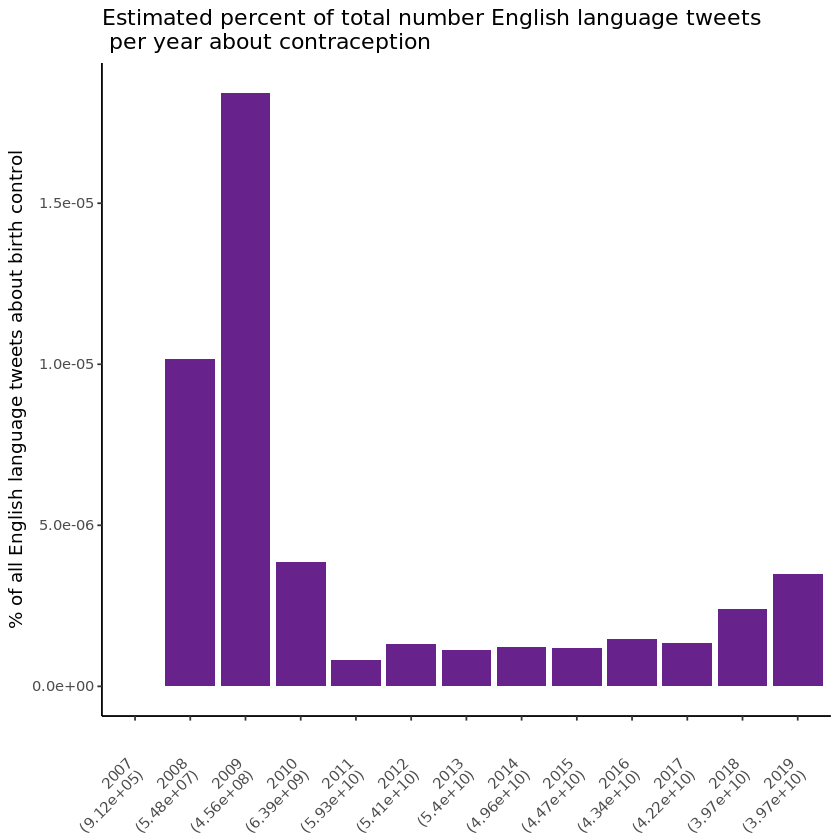

In [38]:
ggplot(tweetPerYear, aes(y=adjusted_bc_tweets, x=xLabel)) + 
  geom_bar(stat="identity", fill = "darkorchid4") + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))+
  ggtitle("Estimated percent of total number English language tweets \n per year about contraception") +
  xlab("" ) +
  ylab( "% of all English language tweets about birth control")+
  theme(axis.text.x = element_text(angle = 45, hjust =1, vjust = 0.5))

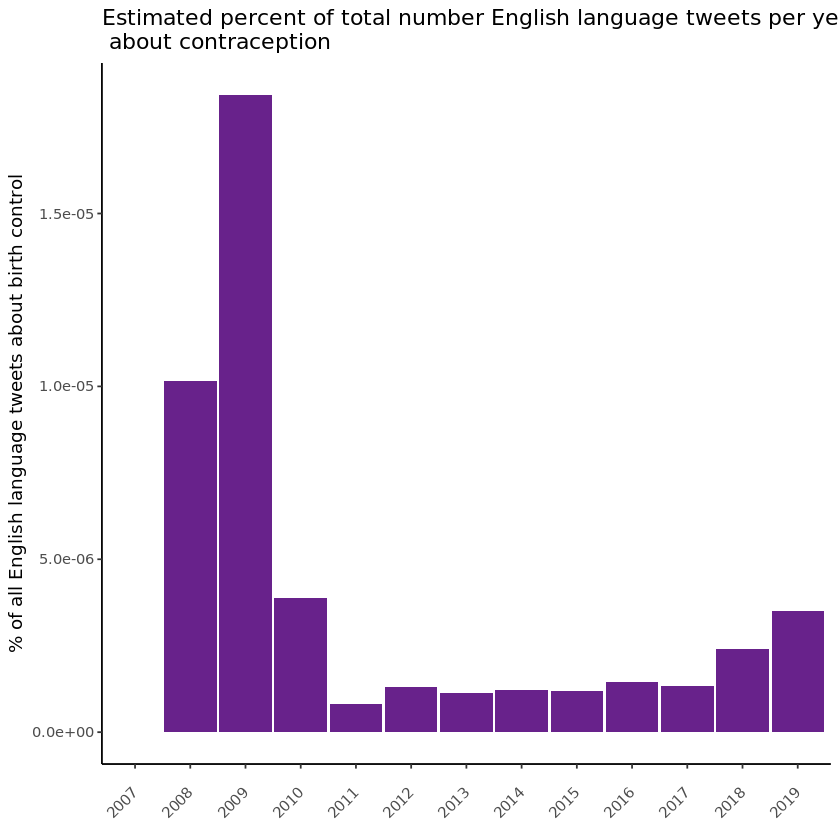

In [39]:
ggplot(tweetPerYear, aes(y=adjusted_bc_tweets, x=yearOnly)) + 
  geom_bar(stat="identity", fill = "darkorchid4", width = 0.95) + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), axis.line = element_line(colour = "black"))+
  ggtitle("Estimated percent of total number English language tweets per year \n about contraception") +
  xlab("" ) +
  ylab( "% of all English language tweets about birth control")+
  theme(axis.text.x = element_text(angle = 45, hjust =1, vjust = 0.5))

In [301]:
install.packages("tm")
install.packages("slam")
library("tm")
library("slam")

also installing the dependencies ‘NLP’, ‘slam’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate



In [303]:
install.packages("wordcloud")
library(wordcloud)
install.packages("RColorBrewer")
library(RColorBrewer)
install.packages("wordcloud2")
library(wordcloud2) 

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [305]:
df <- totalSemiCleanTweets$text

Warning message in brewer.pal(30, "Dark2"):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
“transformation drops documents”

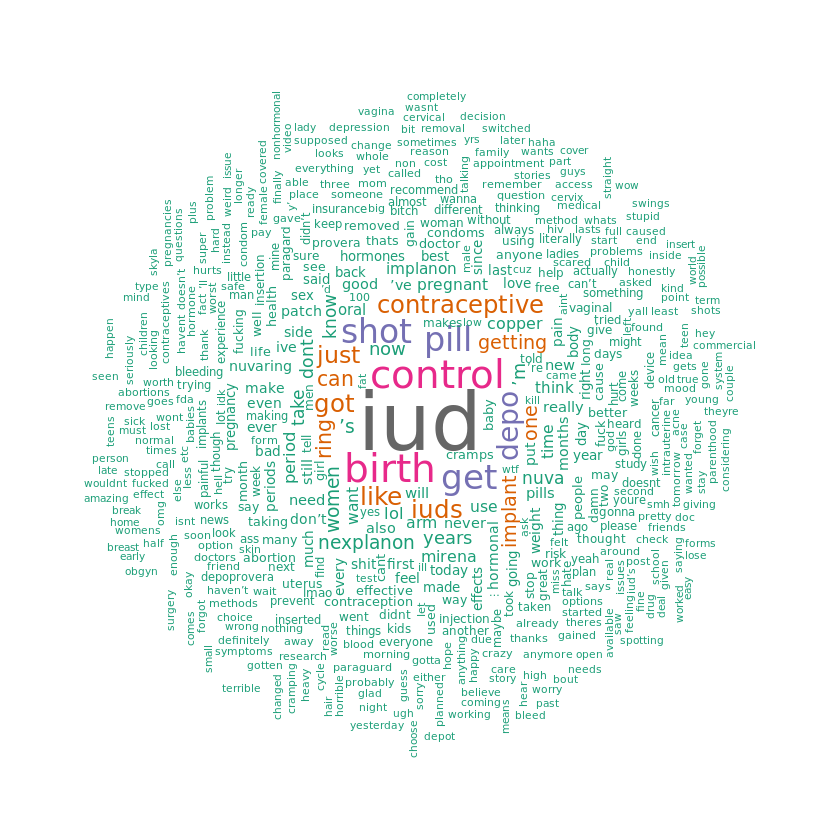

In [309]:
wordcloud(words = df, min.freq = 10, max.words=500, random.order=FALSE, rot.per=0.35, colors=brewer.pal(30, "Dark2"))

In [54]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Amazon Linux AMI 2018.03

Matrix products: default
BLAS/LAPACK: /home/ec2-user/anaconda3/envs/R/lib/R/lib/libRblas.so

locale:
[1] en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] viridis_0.5.1     viridisLite_0.3.0 scales_1.0.0      dplyr_0.8.3      
[5] ggplot2_3.1.1    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.1       magrittr_1.5     tidyselect_0.2.5 munsell_0.5.0   
 [5] uuid_0.1-2       colorspace_1.4-1 R6_2.4.0         rlang_0.4.2     
 [9] plyr_1.8.4       tools_3.6.1      grid_3.6.1       gtable_0.3.0    
[13] withr_2.1.2      htmltools_0.3.6  lazyeval_0.2.2   digest_0.6.18   
[17] assertthat_0.2.1 tibble_2.1.1     crayon_1.3.4     gridExtra_2.3   
[21] IRdisplay_0.7.0  purrr_0.3.2      repr_0.19.2      base64enc_0.1-3 
[25] IRkernel_0.8.15  glue_1.3.1       evaluate_0.13    label